# Testando modelo com Haar Cascade

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score
import os
from PIL import Image
import cv2

In [2]:
model = load_model('./mobilenetv2_finetuned_fer2013_v2.keras')

2025-05-26 11:15:05.147051: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-26 11:15:05.147243: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-26 11:15:05.147249: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1748268905.147679  647641 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1748268905.148115  647641 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/Caskroom/miniforge/base/envs/tf-m1/lib/python3.12/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


In [3]:
# Classes dataset FER2013
emotion_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [4]:
# Carregar o classificador Haarcascade para detecção de rosto
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [5]:
def preprocess_image(image_path, return_cropped_face=False):
    """
    Preprocessa a imagem:
    - Detecta o rosto
    - Redimensiona para (96, 96)
    - Normaliza os valores de pixel
    - Se return_cropped_face=True, retorna também a imagem do rosto recortado
    """
    # Abrir a imagem e converter para RGB
    image = Image.open(image_path).convert("RGB")
    image_array = np.array(image)

    # Converter para escala de cinza para detecção de rosto
    gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

    # Detectar rostos
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Se nenhum rosto for detectado, a imagem será ignorada
    if len(faces) == 0:
        print(f"Nenhum rosto detectado em: {image_path}")
        return (None, None) if return_cropped_face else None

    # Selecionar o maior rosto detectado
    x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])

    # Extrair o rosto e redimensionar para (96, 96)
    face = image_array[y:y+h, x:x+w]
    face_resized = cv2.resize(face, (96, 96))

    # Normalizar e expandir a dimensão para batch
    face_array = face_resized / 255.0
    face_array = np.expand_dims(face_array, axis=0)

    if return_cropped_face:
        return face_array, face_resized
    else:
        return face_array

In [6]:
# Função para realizar a predição e calcular a acurácia
def predict_emotion(image_path, true_label=None):
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction)
    predicted_emotion = emotion_labels[predicted_label]
    confidence = np.max(prediction)

    # Cálculo da acurácia individual
    accuracy = None
    if true_label is not None:
        true_index = emotion_labels.index(true_label)
        accuracy = 1 if predicted_label == true_index else 0

    return predicted_emotion, confidence, accuracy

In [7]:
def predict_emotion(image_path, true_label=None):
    """
    Realiza a predição de emoção a partir de uma imagem.
    - Retorna a emoção prevista, a confiança, a acurácia e o rosto recortado.
    """
    # Pré-processar a imagem e obter o rosto recortado
    processed_image, cropped_face = preprocess_image(image_path, return_cropped_face=True)

    # Se não houver rosto, retorna None
    if processed_image is None:
        return "No face detected", None, None, None

    # Realizar a predição
    predictions = model.predict(processed_image)
    predicted_index = np.argmax(predictions[0])
    predicted_emotion = emotion_labels[predicted_index]
    confidence = predictions[0][predicted_index]

    # Calcular a acurácia, se o true_label for fornecido
    if true_label:
        accuracy = 1.0 if predicted_emotion == true_label else 0.0
    else:
        accuracy = None

    return predicted_emotion, confidence, accuracy, cropped_face


In [8]:
def display_results(image_path, predicted_emotion, confidence, accuracy, cropped_face=None):
    """
    Exibe a imagem do rosto recortado juntamente com o resultado da predição.
    Se não houver rosto recortado, exibe a imagem original.
    """
    if cropped_face is not None:
        image = cropped_face
    else:
        # Carregar a imagem original
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Configurar a exibição
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    
    # Título com informações da predição
    title = f"Predição: {predicted_emotion}\nConfiança: {confidence:.2f}" if confidence else "Sem confiança"
    if accuracy is not None:
        title += f"\nAcurácia: {accuracy:.2f}"
    
    plt.title(title, fontsize=12)
    plt.show()


In [9]:
def process_images(image_folder, true_labels=None):
    """
    Processa imagens em um diretório na ordem alfanumérica e exibe os resultados.
    - image_folder: Diretório contendo as imagens.
    - true_labels: Lista opcional de rótulos verdadeiros.
    """
    # Listar e ordenar imagens alfanumericamente
    image_files = sorted([
        os.path.join(image_folder, f) 
        for f in os.listdir(image_folder) 
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])

    # Verificar correspondência entre imagens e true_labels
    if true_labels and len(true_labels) != len(image_files):
        raise ValueError("O número de rótulos verdadeiros não coincide com o número de imagens.")

    for idx, image_path in enumerate(image_files):
        true_label = true_labels[idx] if true_labels and idx < len(true_labels) else None
        
        # Realizar a predição
        predicted_emotion, confidence, accuracy = predict_emotion(image_path, true_label)
        
        # Exibir os resultados
        display_results(image_path, predicted_emotion, confidence, accuracy)

2025-05-26 11:15:07.935376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


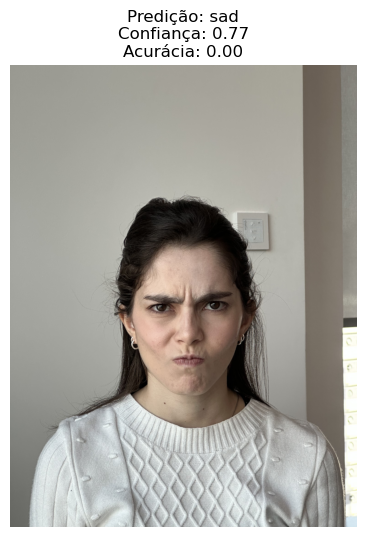

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


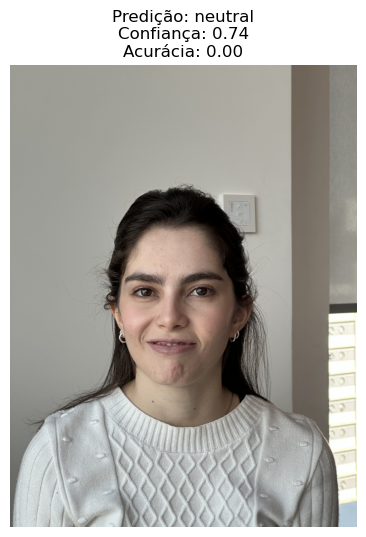

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


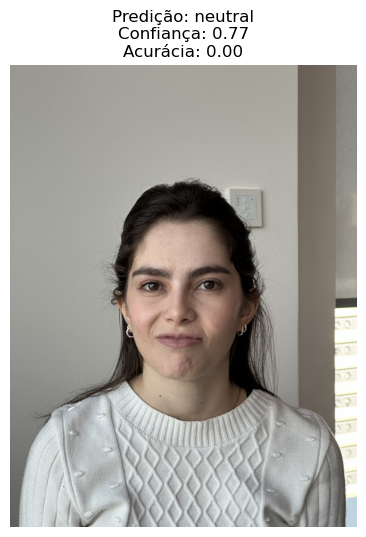

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


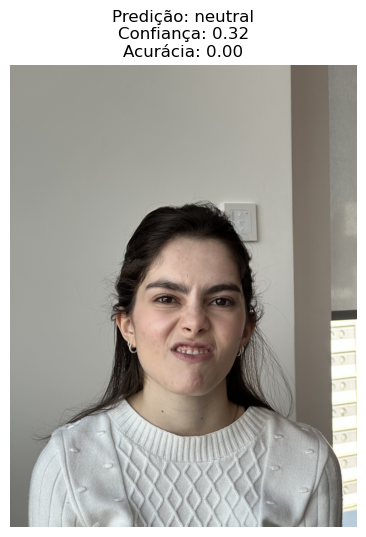

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


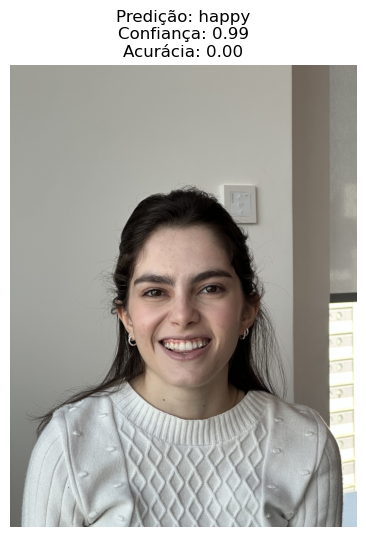

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


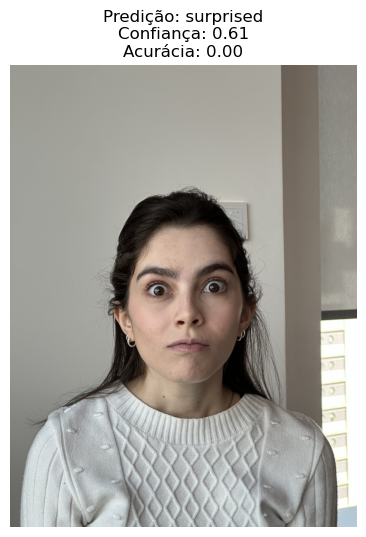

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


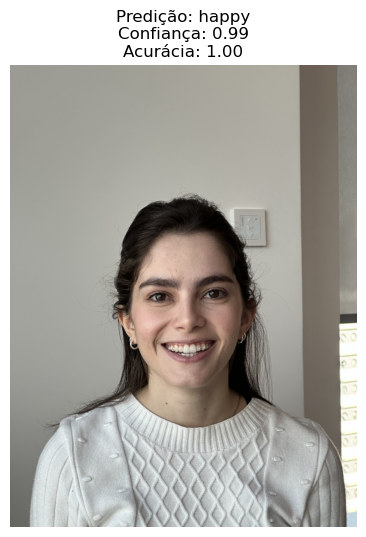

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


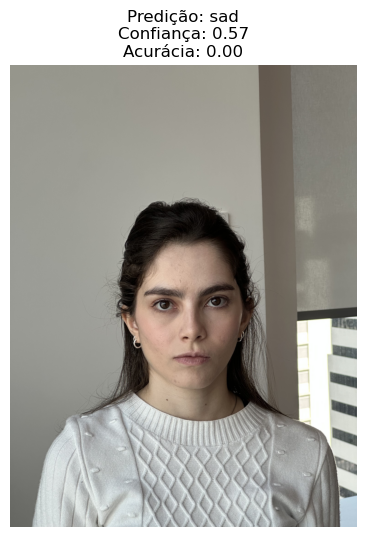

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


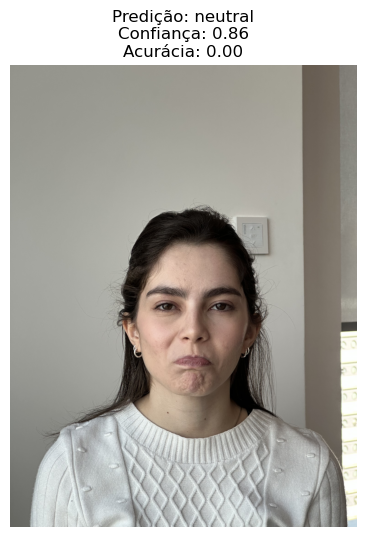

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


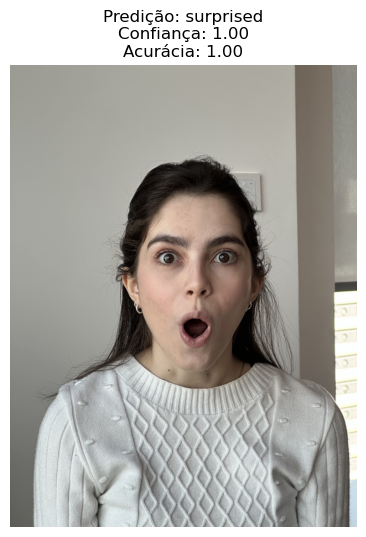

In [10]:
# Exemplo de uso:
image_folder = './images3'
true_labels = ['angry', 'disgusted', 'disgusted', 'disgusted', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']  # Opcional
process_images(image_folder, true_labels)

In [11]:
# # Exemplo de uso:
# image_folder = './images'
# true_labels = ['angry', 'happy', 'sad', 'surprised',]  # Opcional
# process_images(image_folder, true_labels)